In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import textwrap
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zionsheng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load the datasets

In [5]:
# Read dataset
def load_dataset(dataset_path: str) -> pd.DataFrame:
    df = pd.read_csv(dataset_path)
    df.drop(columns=['id'], inplace=True) # Drop id column
    df.dropna(inplace=True) # Drop null values (if any)
    return df

In [6]:
# Load train data
df_train = load_dataset(r'./data/cnn_dailymail/train.csv')
print("Number of records in training set:", len(df_train))
df_train.head()

Number of records in training set: 287113


,article,highlights
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [7]:
df_val = load_dataset(r'./data/cnn_dailymail/validation.csv')
print("Number of records in validation set:", len(df_val))
df_val.head()

Number of records in validation set: 13368


,article,highlights
0,"Sally Forrest, an actress-dancer who graced th...","Sally Forrest, an actress-dancer who graced th..."
1,A middle-school teacher in China has inked hun...,Works include pictures of Presidential Palace ...
2,A man convicted of killing the father and sist...,"Iftekhar Murtaza, 29, was convicted a year ago..."
3,Avid rugby fan Prince Harry could barely watch...,Prince Harry in attendance for England's crunc...
4,A Triple M Radio producer has been inundated w...,Nick Slater's colleagues uploaded a picture to...


In [8]:
df_test = load_dataset(r'./data/cnn_dailymail/test.csv')
print("Number of records in test set:", len(df_test))
df_test.head()

Number of records in test set: 11490


,article,highlights
0,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."


In [9]:
# Print an example article (the article is wrapped for better readability).
example_text = df_train['article'][0]
print(textwrap.fill(text=example_text, replace_whitespace=False,
                    fix_sentence_endings=True))

By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | .
UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo
Catholic Diocese in North Dakota has exposed potentially hundreds of
church members in Fargo, Grand Forks and Jamestown to the hepatitis A
virus in late September and early October.  The state Health
Department has issued an advisory of exposure for anyone who attended
five churches and took communion.  Bishop John Folda (pictured) of the
Fargo Catholic Diocese in North Dakota has exposed potentially
hundreds of church members in Fargo, Grand Forks and Jamestown to the
hepatitis A . State Immunization Program Manager Molly Howell says the
risk is low, but officials feel it's important to alert people to the
possible exposure.  The diocese announced on Monday that Bishop John
Folda is taking time off after being diagnosed with hepatitis A. The
diocese says he contracted the infection through contaminated food
while attending a conference for newly ordaine

As we have seen in the examples above, some sentences appear at the beginning or end of an article that do not pertain to its main content. These sentences typically provide brief details such as the name of the publication, the author, or the date of publication. Hence, it is safe to remove such redundant information from the main body of the article. These sentences are usually shorter than those in the main body, which makes it easier to filter them out when building a summarizer.

## Exploratory Data Analysis

Text(0.5, 1.0, 'Sentence Count')

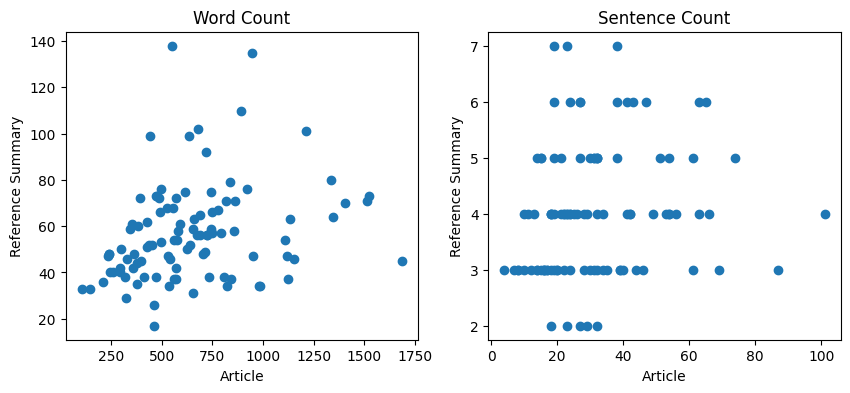

In [29]:
samples = df_val.sample(n=100, random_state=0)

article_wc = [len(article.split()) for article in samples['article']]
summary_wc = [len(summary.split()) for summary in samples['highlights']]
stop_words = stopwords.words('english')

tfidf = TfidfVectorizer(stop_words=stop_words, norm='l1')
article_sc = [len(nltk.tokenize.sent_tokenize(a)) for a in samples['article']]
summary_sc = [len(nltk.tokenize.sent_tokenize(s)) for s in samples['highlights']]

fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(article_wc, summary_wc)
plt.xlabel('Article')
plt.ylabel('Reference Summary')
plt.title('Word Count')
plt.subplot(1, 2, 2)
plt.scatter(article_sc, summary_sc)
plt.xlabel('Article')
plt.ylabel('Reference Summary')
plt.title('Sentence Count')

## Implement the baseline summarizer

In [11]:
# Function to summarize text using TF-IDF

# def get_sentence_score(tokenized_sent): # Function to get score for each sentence
#     x = tokenized_sent[tokenized_sent != 0]
#     return x.mean()

# TODO: add function docs.
# NOTE: summary_len should be a hyperparam.
def summarize(text: str, summary_len: int) -> str:
    # Initialize a TF-IDF Vectorizer
    stop_words = stopwords.words('english')
    tfidf = TfidfVectorizer(stop_words=stop_words, norm='l1')
    # Tokenize sentences (ie, split text into individual sentences)
    sents = nltk.tokenize.sent_tokenize(text)
    # Remove overly short sentences
    sent_lens = [len(sent) for sent in sents]
    avg_sent_len = sum(sent_lens) / len(sent_lens)
    sents = [sent for sent in sents if len(sent) > avg_sent_len * 0.5]
    # Perform TF-IDF
    X = tfidf.fit_transform(sents)
    # Compute each sentence score
    scores = np.zeros(len(sents))
    for i in range(len(sents)):
        tokenized_sent = X[i,:]
        score = tokenized_sent[tokenized_sent != 0].mean()
        scores[i] = score

    # sort the scores
    sort_idx = np.argsort(-scores)
    # Concatenate sentences with top scores as the summary
    summary = ''
    for i in sort_idx[:summary_len]:
        summary += (sents[i] + ' ')
    return summary

In [12]:
# Summary for a row in train data
summarize(df_train['article'][1], 2)

'Since March 2010, he had been working in the internal affairs division. The organization "has been distributing narcotics in New Jersey and elsewhere," the complaint says. '

## Evaluate the candidate summaries